# Multiband histogram matching

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Install modules and import packages

In [ ]:
#install modules
#this module should be installed only the first time you run this code in Colab or when you create a new virtual environment
!pip install rasterio

# import packages
import rasterio as rio
from skimage.exposure import match_histograms

#plot functions
from rasterio.plot import show
from skimage import exposure
import matplotlib.pyplot as plt

## Step 2: Read tiff files

In [ ]:

# Define folder path
folder_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Matching'

# Open the Reference image (Pre-Flood)
pre_flood_path = f'{folder_path}/pre_flood_clipped.tif'
with rio.open(pre_flood_path, 'r') as r:
    pre_flood = r.read()
    metadata_pre_flood = r.profile
    metadata_pre_flood.update(compress='deflate')

# Open the Secondary image (Post-Flood)
post_flood_path = f'{folder_path}/post_flood_clipped.tif'
with rio.open(post_flood_path, 'r') as s:
    post_flood = s.read()
    metadata_post_flood = s.profile
    metadata_post_flood.update(compress='deflate')

# Replace NaN with 0 in the input images if necessary
post_flood = np.nan_to_num(post_flood, nan=0)

# Initialize an array to store matched bands
matched_bands = np.zeros_like(post_flood)




## Step 3: Histogram matching for each band and save it individually

In [ ]:
# Match histogram of each band for all data
file_list = []
for band in range(post_flood.shape[0]):  # Using post_flood as the secondary image
    # Perform histogram matching for each band
    matched_band = match_histograms(post_flood[band], pre_flood[band], channel_axis=None)

    # Store matched band in the output array
    matched_bands[band] = matched_band

    # Save each band as an individual file
    file_path = f"{folder_path}/post_flood_band_{band+1}_matched.tif"
    file_list.append(file_path)

    # Create single-band raster file for each histogram-matched band
    single_band_meta = metadata_post_flood.copy()
    single_band_meta.update(count=1, dtype=matched_band.dtype)  # Ensure single-band and correct data type

    with rio.open(file_path, 'w', **single_band_meta) as dstBand:
        dstBand.write(matched_band, 1)


## Step 4: Create the mutliband raster ans save it in the Google Drive Folder

In [ ]:
# Create a multiband raster with matched bands
with rio.open(file_list[0], 'r') as src0:
    meta = src0.meta

# Update metadata to reflect the number of bands
meta.update(count=len(file_list))

# Create and save the multiband image
matched_post_flood_path = f'{folder_path}/matched_post_flood_image.tif'
with rio.open(matched_post_flood_path, 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rio.open(layer, 'r') as src1:
            dst.write_band(id, src1.read(1))

print(f"Matched image saved at: {matched_post_flood_path}")

Matched image saved at: /content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Matching/matched_post_flood_image.tif


## Step 5: Plot the blue band of the pre-flood image, post-flood image and matched post-flood image

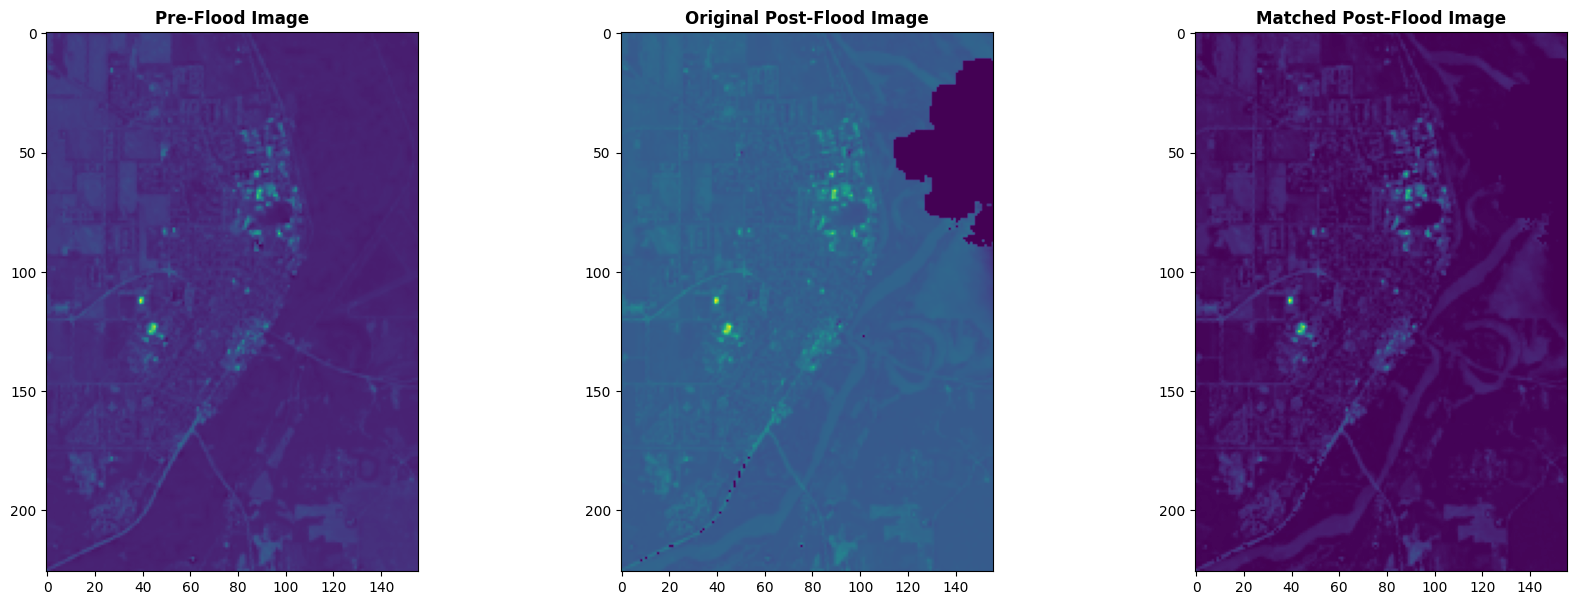

In [ ]:
# Visualize the images after histogram matching
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

# Normalize and visualize the pre-flood image
pre_flood_norm = (pre_flood[0] - pre_flood[0].min()) / (pre_flood[0].max() - pre_flood[0].min())
show(pre_flood_norm, ax=ax[0], title="Pre-Flood Image")

# Normalize and visualize the original post-flood image
post_flood_norm = (post_flood[0] - post_flood[0].min()) / (post_flood[0].max() - post_flood[0].min())
show(post_flood_norm, ax=ax[1], title="Original Post-Flood Image")

# Load and visualize the matched post-flood image
with rio.open(matched_post_flood_path, 'r') as s:
    matched_post_flood = s.read()
matched_norm = (matched_post_flood[0] - matched_post_flood[0].min()) / (matched_post_flood[0].max() - matched_post_flood[0].min())
show(matched_norm, ax=ax[2], title="Matched Post-Flood Image")

plt.show()

## Step 6: Plot the Histograms

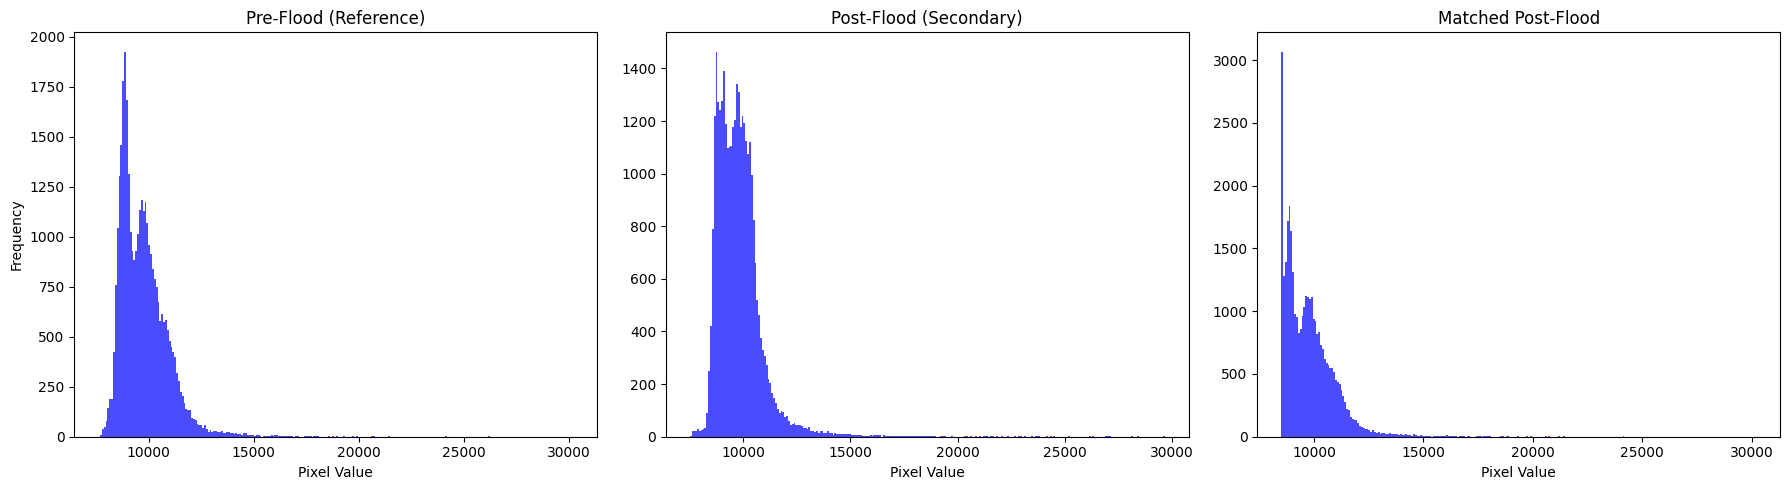

In [ ]:
# Paths to images
pre_flood_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Matching/pre_flood_clipped.tif'
post_flood_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Matching/post_flood_clipped.tif'
matched_post_flood_path = '/content/drive/MyDrive/Colab Notebooks/Flood Detection and Damage Assesment 2/Matching/matched_post_flood_image.tif'

# Open images and read Band 2 (Blue)
with rio.open(pre_flood_path) as src:
    pre_flood_band2 = src.read(2)  # Band 2

with rio.open(post_flood_path) as src:
    post_flood_band2 = src.read(2)  # Band 2

with rio.open(matched_post_flood_path) as src:
    matched_post_flood_band2 = src.read(2)  # Band 2

# Plot histograms
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Histogram for Pre-Flood Image (Reference)
axes[0].hist(pre_flood_band2.flatten(), bins=256, color='blue', alpha=0.7)
axes[0].set_title('Pre-Flood (Reference)')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')

# Histogram for Post-Flood Image (Secondary)
axes[1].hist(post_flood_band2.flatten(), bins=256, color='blue', alpha=0.7)
axes[1].set_title('Post-Flood (Secondary)')
axes[1].set_xlabel('Pixel Value')


# Histogram for Matched Post-Flood Image
axes[2].hist(matched_post_flood_band2.flatten(), bins=256, color='blue', alpha=0.7)
axes[2].set_title('Matched Post-Flood')
axes[2].set_xlabel('Pixel Value')

# Show plot
plt.tight_layout()
plt.show()